### LangGraph Basics Overview

- Tutorial: [langgraph basics](https://langchain-ai.github.io/langgraph/tutorials/introduction/)

In [ ]:
import os, sys, getpass
from anthropic import Anthropic
from langchain_anthropic import ChatAnthropic

#Import API Keys        
_root = "/home/zjc1002/Mounts/code/admin/"
sys.path.append(_root)
from api_keys import _api_keys

#set Environment Variables 
def _set_env(var: str,value: str = None):
    if not os.environ.get(var):
        os.environ[var] = value
        #getpass.getpass(f"{var}: ")

In [14]:
#SET ANTHROPIC API KEY ENV VAR
_set_env("ANTHROPIC_API_KEY"
         ,value =  _api_keys['ANTHROPIC_API_KEY'])


# Initialize the Anthropic client
client = Anthropic(api_key=_api_keys['ANTHROPIC_API_KEY'])

# Get available models
available_models = client.models.list()

# Print the available models
for model in available_models.data:
    print(f"Model ID: {model.id}")

    # The context_window property contains the maximum number of tokens
    if hasattr(model, 'context_window'):
        print(f"Max context length: {model.context_window} tokens")

Model ID: claude-3-7-sonnet-20250219
Model ID: claude-3-5-sonnet-20241022
Model ID: claude-3-5-haiku-20241022
Model ID: claude-3-5-sonnet-20240620
Model ID: claude-3-haiku-20240307
Model ID: claude-3-opus-20240229
Model ID: claude-3-sonnet-20240229
Model ID: claude-2.1
Model ID: claude-2.0


### Select LLM TO  use in chatbot

In [15]:
#load model to use in chatbot (use tiny model that is cheap)
_model_id = "claude-3-haiku-20240307"

### **Part 1: Build simple chatbot**

##### A. Create a ***StateGraph***. A StateGraph object defines the structure of our chatbot as a "state machine". 
  - **Nodes**  represent the llm and functions our chatbot can call 
    - *Nodes represent units of work, they are typically regular python functions*
  - **Edges**  specify how the bot should transition between these functions.


***Note:*** *the Graph State includes the graphs SCHEMA and REDUCER FUNCTIONS  which handel state updates.* **add_messages()** is the reducer function used in this example to append new messages to the list instead of replacing them. Keys without a reducer annotation will overwrite previous values  

##### B. Add a chatbot Node to StateGraph()
 - The **chatbot node** function takes the current State as input and returns a dictionary containing an updated messages list under the key "messages". **This is the basic pattern for all LangGraph node functions.**


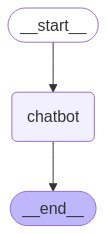

In [16]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.runnables import RunnableConfig

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # in this case we use the reducer function add_messages to  append messages to the list, rather than overwriting them
    messages: Annotated[list, add_messages]

#define config schemea to use to pass configurable parameters in your API 
#as example i add a string paramter that will be prefixed to each message (not a good idea, but illistrates how to use config)
class ConifgSchema(TypedDict):
    prefix: str 


#basic state
# The state is a dictionary that contains the current state of the graph
# the config contains paramters you want to pass to the node operations
graph_builder = StateGraph(State, config_schema=ConifgSchema)


### Add a chatbot Node to the graph
llm = ChatAnthropic(model=_model_id)

# Note: the chatbot node function takes the current State as input and returns a dictionary containing an updated messages list under the key "messages". **This is the basic pattern for all LangGraph node functions.**
def chatbot(state: State, config: RunnableConfig)-> dict:
    prefix = config['configurable'].get("prefix","")
    _message = llm.invoke(state["messages"])
    
    return {"messages": [_message]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever the node is used.
graph_builder.add_node("chatbot", chatbot)


#Next, add an entry point. This tells our graph where to start its work each time we run it.
graph_builder.add_edge(START, "chatbot")

#set an exit point. This tells the graph "any time this node is run, you can exit."
graph_builder.add_edge("chatbot", END)

# Finally, we compile the graph. This will check for any errors in the graph and prepare it for use. This creates a new class that we can use to run the graph.
# The compiled graph is a subclass of the original graph builder, so we can still use the same methods.
# The compiled graph will have a new name, so we can use it to run the graph.
# This will also create a new class that we can use to run the graph.
graph = graph_builder.compile() 

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

##### Run the Chatbot

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        #import pdb;pdb.set_trace();
        
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
            print(value["messages"][-1].response_metadata.keys())
            print(f"Message ID: {value['messages'][-1].response_metadata['id']}")
            print(f"Model Used: {value['messages'][-1].response_metadata['model']}")
            print(f"Chat Stop Reason: {value['messages'][-1].response_metadata['stop_reason']}")
            print(f"Chat Stop Sequence: {value['messages'][-1].response_metadata['stop_sequence']}")
            print(f"Chat usage: {value['messages'][-1].response_metadata['usage']}")

# This is a simple loop to get user input and stream the graph updates
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: I'm afraid I don't have enough context to determine who "Mike" is without more information. "Mike" could refer to a wide variety of people, as it is a common first name. Can you provide some additional details about who you are asking about? That would help me try to understand who the specific "Mike" you are referring to is.
dict_keys(['id', 'model', 'stop_reason', 'stop_sequence', 'usage', 'model_name'])
Message ID: msg_016ZjLXK7vY4Fpk4YcgLp576
Model Used: claude-3-haiku-20240307
Chat Stop Reason: end_turn
Chat Stop Sequence: None
Chat usage: {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 11, 'output_tokens': 75}
Goodbye!


### **Part 2: Enhance Chatbot with Tools**
 1. Specify tavily api key (tavily is used to search internet like google but designed for llms)
 2. Define the tool TavilySearchResults to inovke 
 3. Rebuild the chatbot from parrt one with **bind_tools** added to the llm. (this tells llm how to format json get/post requests when using the tavily search api)
 4. Add tools to a new node in the **STATEGRAPH** to create function to run tools if called 
    - ***BasicToolNode*** is a class that checks the most recent message in the ***STATE*** instance and calls tools if the message contains **tool_calls**. Langchain provides a prebuilt ***ToolNode*** class to abstract this if building from scratch is to painful
 5. Define ***conditional edges*** to route the contorl flow from one note to another. *Conditional Edges* usually ocntain  'if' statements to route to different nodes depending on the current graph state.  These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.
    - Note: the prebuilt *tools_condition()* method should be used in production , we define our tool router manually for instructive purposes


In [26]:
from langchain_community.tools.tavily_search import TavilySearchResults

# This tool requires an API key to be set in the environment variable TAVILY_API_KEY
_set_env("TAVILY_API_KEY"
         ,value =  _api_keys['TAVILY_API_KEY'])

#DEFINE THE TOOL 
tool = TavilySearchResults(max_results=2)
tools = [tool]

# The tool will return a dictionary with the results
print(f"<b>THIS IS A TEST TO SHOW FORMAT OF TAVILY RESPONSE:</b> \n\n{tool.invoke('who is zachary carideo?')}")

<b>THIS IS A TEST TO SHOW FORMAT OF TAVILY RESPONSE:</b> 

[{'title': 'Zachary Carideo - Lead Data Scientist (Machine Learning Center of ...', 'url': 'https://www.zoominfo.com/p/Zachary-Carideo/-2145059615', 'content': 'Zachary Carideo is a Lead Data Scientist (Machine Learning Center of Excellence) at Wells Fargo based in San Francisco, California. Previously, Zachary was', 'score': 0.8812988}, {'title': 'Zachary Carideo Email & Phone Number | Wells Fargo - ContactOut', 'url': 'https://contactout.com/Zachary-Carideo-27251321', 'content': "What is Zachary Carideo's role at Wells Fargo? Zachary Carideo is Lead Data Scientist (Machine Learning Center of Excellence). What is Zachary Carideo's Phone", 'score': 0.8548001}]


In [28]:
import json 
from langchain_core.messages import ToolMessage
from typing_extensions import TypedDict

#DEFINE THE GRAPH 

#SAME AS PT 1
class State(TypedDict):
    messages: Annotated[list, add_messages]


class ConifgSchema(TypedDict):
    use_tavily: bool 


graph_builder = StateGraph(State)
llm = ChatAnthropic(model=_model_id)


# NEW TO PART2
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


# Note: the chatbot node function takes the current State as input and returns a dictionary containing 
# an updated messages list under the key "messages". **This is the basic pattern for all LangGraph node functions.
# NOTE: here you  can use the  config to pass parameters into the tools you are calling (here Tavily Search parameters)
def chatbot(state: State, config: RunnableConfig)-> dict:
    _use_internet = config['configurable'].get("use_tavily",False)
    _message = llm_with_tools.invoke(state["messages"])
    return {"messages": [_message]}


graph_builder.add_node("chatbot", chatbot)


# Add a BasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls. 
# It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.
class BasicToolNode: 

    """A node that runs the tools requested in the  last AIMessage"""

    def __init__(self
                 ,tools: list
                 ) -> None: 
        
        self.tools_by_name = {t.name: t for t in tools}
    
    def __call__(self,inputs: dict): 

        # Check the most recent message in the state and call tools if the message contains tool_calls
        # check if the last message is a tool call
        # if the last message is a tool call, run the tools
        # if the last message is not a tool call, return the inputs

        #Note: in python empty collections(like []) are considered False, while non-empty collections are considered True
        if messages := inputs.get("messages",[]): 
            message = messages[-1]
            print(isinstance(message, ToolMessage))
        else: 
            raise ValueError('No Messages Found in inputs')


        outputs = []
        for tool_call in message.tool_calls: 
            
            #import pdb;pdb.set_trace();
            #run the tool and get the result
            tool_result = self.tools_by_name[tool_call['name']].invoke(tool_call['args']
                                                                       )
            #add the result to the outputs list
            outputs.append(
                ToolMessage(content=json.dumps(tool_result),
                            name = tool_call['name'], 
                            tool_call_id = tool_call["id"]
                            )
            )

        return {'messages': outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [29]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """

    #get the message if it exists
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    #If message exists check if a tool has been referenced 
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools"
     , END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass



#RUN IT 
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: I'm afraid I don't have enough context to provide a meaningful response to just "hello". As an AI assistant, I'm designed to have natural conversations and provide helpful information to users. Could you please rephrase your request or provide more details about what you'd like assistance with? I'll be happy to try my best to help once I understand the specifics of your needs.
dict_keys(['id', 'model', 'stop_reason', 'stop_sequence', 'usage', 'model_name'])
Message ID: msg_01UiRVJW3nPC7ga1s9DZSVVX
Model Used: claude-3-haiku-20240307
Chat Stop Reason: end_turn
Chat Stop Sequence: None
Chat usage: {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 368, 'output_tokens': 81}
Goodbye!
